# Clustering Scifi Stories
I scraped these from Tor.com

### Instructions:

Pick texts: >100 entries, >10 authors, similar type of texts.

Reserve 25% of your corpus as a test set.

The first technique is to create a series of clusters. Try several techniques and pick the one you think best represents your data. Make sure there is a narrative and reasoning around why you have chosen the given clusters. Are authors consistently grouped into the same cluster?

Next, perform some unsupervised feature generation and selection using the techniques covered in this unit and elsewhere in the course. Using those features then build models to attempt to classify your texts by author. Try different permutations of unsupervised and supervised techniques to see which combinations have the best performance.

Lastly return to your holdout group. Does your clustering on those members perform as you'd expect? Have your clusters remained stable or changed dramatically? What about your model? Is it's performance consistent?

If there is a divergence in the relative stability of your model and your clusters, delve into why.

Your end result should be a write up of how clustering and modeling compare for classifying your texts. What are the advantages of each? Why would you want to use one over the other? Approximately 3-5 pages is a good length for your write up, and remember to include visuals to help tell your story!

### Instruction B
A. Start
1. Go out and find a dataset of interest. It could be one that helps you work on one of our recommended research questions, or any other dataset that addresses an unsupervised learning question of your own.
2. Explore the data. Get to know the data. Spend a lot of time going over its quirks and peccadilloes. You should understand how it was gathered, what's in it, and what the variables look like.
3. You should try several different approaches and really work to tune a variety of models before choosing what you consider to be the best performer.

B.Things to keep in mind: 
4. how do clustering and modeling compare? What are the advantages of each? Why would you want to use one over the other?
Go out and find a dataset of interest. It could be one that helps you work on one of our recommended research questions, or any other dataset that addresses an unsupervised learning question of your own.
5. Explore the data. Get to know the data. Spend a lot of time going over its quirks and peccadilloes. You should understand how it was gathered, what's in it, and what the variables look like.
6. You should try several different approaches and really work to tune a variety of models before choosing what you consider to be the best performer.
7. Things to keep in mind: how do clustering and modeling compare? What are the advantages of each? Why would you want to use one over the other?

C. Be prepared to talk about:
1. Your end-user and the value your project provides to them.
1. Quantifiable results based on the research you’ve conducted.
1. The visuals you chose and what they represent for your research.
1. Next steps you'd take to expand on your work.
1. A specified research question your model addresses.
1. How you chose your model specification and what alternatives you compared it to.
1. The practical uses of your model for an audience of interest.
1. Any weak points or shortcomings of your model.


# Data Scraping

In [ ]:
import scrapy
import scrapy.crawler
from scrapy.crawler import CrawlerProcess
process = CrawlerProcess({'AUTOTHROTTLE_ENABLED': True, # or download delay
                          'HTTPCACHE_ENABLED': True, # remove for final scrape to get live data
                          'ROBOTSTXT_OBEY': True, 
                          'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
                          'FEED_URI': 'sf_stories.csv',
                          'FEED_FORMAT': 'csv',
                          'FEED_EXPORT_ENCODING': '"utf-8"'})
class TorSpider(scrapy.Spider):
    name = 'tors'
    base_url = 'https://www.tor.com/category/all-fiction/original-fiction/page/{}'
    page = 1
    start_urls = [base_url.format(1), base_url.format(2)]] #first url lacks number
    def parse(self, response):
        # example //*[@id="post-497584"]/header/h2/a
        for item in response.xpath("//*[starts-with(@id,'post-')]/header/h2/a/@href"):
            item_url = response.urljoin(item.extract())
            yield scrapy.Request(item_url, callback=self.story)
        #if response.xpath("//*[@id='infinite-handle']/span/button").extract():
        #page = response.request.url[63:64] if response.request.url[63:].find('/') else response.request.url[63:65]
        page = response.request.url[63:(response.request.url[63:].find('/'))]
        if page == "":
            page = 1 
        page = int(page)
        page += 1
        yield scrapy.Request(self.base_url.format(page))
                                    
    def story(self, response):
        # example //*[@id="post-497584"]/div
        # //*[@id="post-497584"]/header/h2/a
        # //*[@id="post-497584"]/div
        yield {'Title': response.xpath("//*[starts-with(@id,'post-')]/header/h2/a/text()").extract(),
               'Author': response.xpath("//*[starts-with(@id,'post-')]/header/a/text()").extract(),
               #//*[@id="post-497584"]/div/p[7]
               'Body': response.xpath("//*[starts-with(@id,'post-')]/div/p/text()").extract()}


process.crawl(TorSpider)
process.start()

# Setup

In [290]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from scipy.sparse import hstack

from nltk.tokenize import word_tokenize
# nltk.download('punkt')

from nltk.stem.wordnet import WordNetLemmatizer
#nltk.download('wordnet')

from nltk import pos_tag
from nltk.corpus import stopwords as nltkstopwords
from nltk import bigrams

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from sklearn.metrics import adjusted_rand_score

#classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier


# Exploration

In [300]:
stories_df = pd.read_csv('sf_stories.csv')

In [301]:
stories_df.head()

,Title,Author,Body
0,One/Zero,Kathleen Ann Goonan,"In war-torn Kurdistan, a group of traumatized ..."
1,Blue Morphos in the Garden,Lis Mitchell,When Vivian and her daughter witness the famil...
2,Painless,Rich Larson,A man who can’t feel pain has been bioengineer...
3,Mama Bruise,Jonathan Carroll,A couple is concerned when their dog behaves i...
4,"The Mongolian Wizard Stories,Murder in the Spo...",Michael Swanwick,A brand new story in the Mongolian Wizard univ...


In [302]:
stories_df.Author.value_counts()

Rich Larson                        4
Max Gladstone                      3
Jonathan Carroll                   3
Julianna Baggott                   3
Lavie Tidhar                       3
                                  ..
A.C. Wise                          1
Annalee Newitz                     1
Yoon Ha Lee                        1
Caroline Spector,Bradley Denton    1
Ploy Pirapokin                     1
Name: Author, Length: 122, dtype: int64

In [303]:
stories_df["Author"].value_counts().value_counts()

1    102
2     14
3      5
4      1
Name: Author, dtype: int64

# Cleaning and Processing

In [304]:
stopwords = nltkstopwords.words('english')
punct = set(string.punctuation)
lem = WordNetLemmatizer()
def text_cleaner(text):
    text = text.lower()
    cleantext1 = " ".join(word for word in text.split() if word not in punct)
    cleantext2 = " ".join(word for word in cleantext1.split() if word not in stopwords)
    
    def lem_and_token(txt):
        '''tokenizes, and lemmatizes based on word position'''
        return [lem.lemmatize(i,j[0].lower()) if j[0].lower() in ['a','n','v'] else lem.lemmatize(i) \
                 for i, j in pos_tag(word_tokenize(txt))]

    cleantext3 = lem_and_token(cleantext2)
    return cleantext3

In [305]:
stories_df["tokenized_words"] = stories_df.Body.apply(text_cleaner)

In [306]:
stories_df.head()

,Title,Author,Body,tokenized_words
0,One/Zero,Kathleen Ann Goonan,"In war-torn Kurdistan, a group of traumatized ...","[war-torn, kurdistan, ,, group, traumatize, or..."
1,Blue Morphos in the Garden,Lis Mitchell,When Vivian and her daughter witness the famil...,"[vivian, daughter, witness, family, matriarch,..."
2,Painless,Rich Larson,A man who can’t feel pain has been bioengineer...,"[man, can, ’, t, feel, pain, bioengineered, ki..."
3,Mama Bruise,Jonathan Carroll,A couple is concerned when their dog behaves i...,"[couple, concerned, dog, behaves, increasingly..."
4,"The Mongolian Wizard Stories,Murder in the Spo...",Michael Swanwick,A brand new story in the Mongolian Wizard univ...,"[brand, new, story, mongolian, wizard, univers..."


In [307]:
#Create bigrams feature
stories_df["bgrams"] = stories_df.tokenized_words.apply(lambda x: list(bigrams(x)))

In [308]:
# term frequency-inverse document frequncy
vectorizer = TfidfVectorizer(stop_words='english')

In [310]:
X_tfidf = vectorizer.fit_transform(stories_df.tokenized_words.apply(lambda x: " ".join(x)))

In [311]:
X_tfidf_tr, X_tfidf_te, y_train, y_test = train_test_split(X_tfidf, stories_df.Author, test_size=.25)

# Clustering

In [312]:
# k-means++ givens evenly distributed starting pts
kmean = KMeans(n_clusters=10, init='k-means++', max_iter=200, n_init=100)
kmean.fit(X_tfidf_tr)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=200,
       n_clusters=10, n_init=100, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [313]:
X_tfidf_norm = normalize(X_tfidf_tr.toarray())
X_tfidf_pca = PCA(2).fit_transform(X_tfidf_norm)

def visualize_clusters(model, name, Xpca=X_tfidf_pca, X=X_tfidf_tr):
    '''shows cluster on 2d plot of top 2 principal components'''
    y_pred = model.fit_predict(X)
    y_pred = pd.Series(y_pred).apply(lambda x: chr(x+97)) # stop sns using sequential color palette

    sns.set_style('darkgrid')
    sns.set_palette('deep')
    sns.scatterplot(x=Xpca[:, 0], y=Xpca[:, 1], hue=y_pred)
    plt.title("Clusters from {}".format(name));

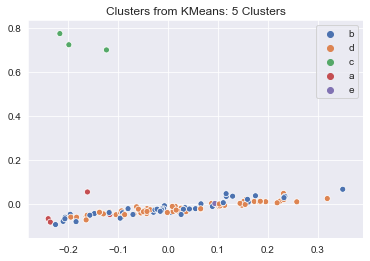

In [314]:
k_means5 = KMeans(n_clusters=5, init='k-means++', max_iter=200, n_init=100)
visualize_clusters(k_means5, "KMeans: 5 Clusters");

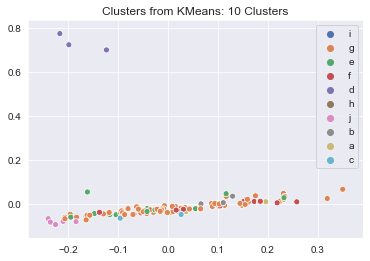

In [315]:
k_means10 = KMeans(n_clusters=10, init='k-means++', max_iter=200, n_init=100)
visualize_clusters(k_means10, "KMeans: 10 Clusters");

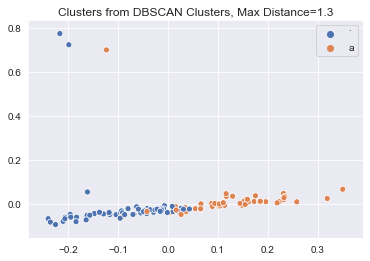

In [316]:
#DBSCAN was very sensitive to eps, 
#only small range of hypers worked to segment into a set of clusters with multiple points
DBs1 = DBSCAN(eps=1.3)
visualize_clusters(DBs1, "DBSCAN Clusters, Max Distance=1.3");

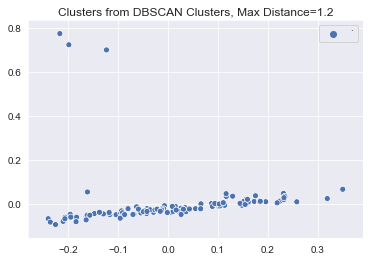

In [317]:
DBs2 = DBSCAN(eps=1.2)
visualize_clusters(DBs2, "DBSCAN Clusters, Max Distance=1.2");

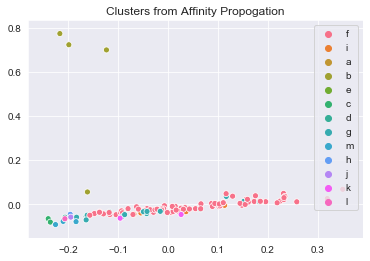

In [318]:
affprop = AffinityPropagation()
visualize_clusters(affprop, "Affinity Propogation");

## Compare Clusterings by Score

In [319]:
X1A, X3A, y1A, y3A = train_test_split(X_tfidf_tr, y_train, test_size=.5)
X1, X2, y1, y2 = train_test_split(X1A, y1A, test_size=.5)
X3, X4, y3, y4 = train_test_split(X3A, y3A, test_size=.5)
Xset= [X1, X2, X3, X4]

In [320]:
def sil_score(model, X_set=Xset):
    score = []
    for sample in X_set:
        model = model.fit(sample)
        labels = model.labels_
        score.append(silhouette_score(sample, labels, metric='euclidean'))
    return score

In [321]:
cluster_score_df = pd.DataFrame(columns=["X1", "X2", "X3", "X4"])
cluster_score_df.loc["affprop"] = sil_score(affprop)
#too few clusters to run on subsample without error given min requirements for silhouette score
#cluster_score_df.loc["DBs1"] = sil_score(DBs02)
#cluster_score_df.loc["DBs03"] = sil_score(DBs03)
cluster_score_df.loc["k_means10"] = sil_score(k_means10)
cluster_score_df.loc["k_means5"] = sil_score(k_means5)
cluster_score_df["mean_score"] = cluster_score_df.mean(axis=1)

In [322]:
#add adjusted rand score column
cluster_score_df["Adjusted_Rand"] = np.nan
cluster_score_df.loc["affprop", "Adjusted_Rand"] = adjusted_rand_score(y_train, affprop.fit(X_tfidf_tr).labels_)
cluster_score_df.loc["k_means10", "Adjusted_Rand"] = adjusted_rand_score(y_train, k_means10.fit(X_tfidf_tr).labels_)
cluster_score_df.loc["k_means5", "Adjusted_Rand"] = adjusted_rand_score(y_train, k_means5.fit(X_tfidf_tr).labels_)

In [323]:
cluster_score_df

,X1,X2,X3,X4,mean_score,Adjusted_Rand
affprop,0.020230,0.003430,0.022095,0.016694,0.015612,0.003361
k_means10,0.005958,0.003873,0.008178,0.010974,0.007246,0.003299
k_means5,0.011911,0.004132,0.015539,0.010148,0.010433,0.000842


While some authors have multiple stories, the majority of the texts are one-offs. Thus, for an ideal Rand score, the clusters should be singletons for these authors. This may not be ideal for what we really want the clusters to be doing; we would choose classification if that were the goal.

# Classification

In [324]:
logit = LogisticRegression()
nbayes = MultinomialNB()
KNNc = KNeighborsClassifier()
